In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.models import SVGP, SGPR
from gpflow.utilities import read_values, multiple_assign, set_trainable
from gpflow.inducing_variables import InducingPoints

import invgp
from invgp.models.SampleSVGP import SampleSVGP
import invgp.kernels.orbits as orbits
from invgp.inducing_variables.invariant_convolution_domain import StochasticConvolvedInducingPoints

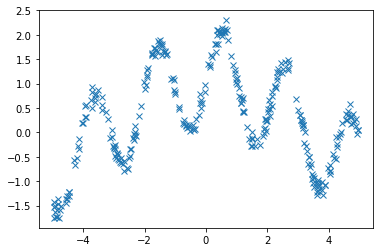

In [2]:
pX = np.linspace(-10.0, 10.0, 300)[:, None]
X = np.random.uniform(-5, 5, 300)[:, None]
Y = np.sin(3 * X) + 0.1  +  np.cos(0.5 * X) + np.random.randn(*X.shape) * 0.1
Z = np.linspace(-5, 5, 50)[:, None]

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

plt.plot(X,Y ,"x")

In [3]:
from gpflow.covariances.dispatch import Kuf, Kuu
from gpflow.kernels import SquaredExponential
from gpflow.utilities.ops import square_distance

class GaussianNoiseInvariant(SquaredExponential):
    def __init__(self, base_variance=1.0, base_lengthscales=1.0, orbit_variance=1.0):
        self.base_variance = gpflow.Parameter(base_variance, transform=gpflow.utilities.bijectors.positive())
        self.base_lengthscales = gpflow.Parameter(base_lengthscales, transform=gpflow.utilities.bijectors.positive())
        self.orbit_variance = orbit_variance
        super().__init__()

    @property
    def lengthscales(self):
        return (self.base_lengthscales ** 2.0 + 2 * self.orbit_variance) ** 0.5

    @lengthscales.setter
    def lengthscales(self, x):
        pass

    @property
    def variance(self):
        return (self.base_lengthscales ** 2.0 / self.lengthscales ** 2.0) ** 0.5 * self.base_variance

    @variance.setter
    def variance(self, x):
        pass


class GaussianNoiseInvariantInducing(gpflow.inducing_variables.InducingPoints):
    pass


@Kuu.register(GaussianNoiseInvariantInducing, GaussianNoiseInvariant)
def Kuu_temp(inducing_variable, kernel, *, jitter=0.0):
    X_scaled = inducing_variable.Z / kernel.base_lengthscales
    r2 = square_distance(X_scaled, None)
    return kernel.base_variance * tf.exp(-0.5 * r2) + jitter * tf.eye(len(inducing_variable), dtype=r2.dtype)


@Kuf.register(GaussianNoiseInvariantInducing, GaussianNoiseInvariant, object)
def Kuf_temp(inducing_variable, kernel, Xnew):
    ls = (kernel.base_lengthscales ** 2.0 + kernel.orbit_variance) ** 0.5
    X_scaled = Xnew / ls
    Z_scaled = inducing_variable.Z / ls
    r2 = square_distance(Z_scaled, X_scaled)
    return kernel.base_variance * (kernel.base_lengthscales ** 2.0 / ls ** 2.0) ** 0.5 * tf.exp(-0.5 * r2)

In [4]:
orbit_variance = 0.1

det_k = GaussianNoiseInvariant(orbit_variance=orbit_variance)

In [22]:
SVGPmodel = SVGP(det_k, likelihood = gpflow.likelihoods.Gaussian(), inducing_variable=GaussianNoiseInvariantInducing(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = SVGPmodel.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam(0.01)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGPmodel.trainable_variables)
elbo_hist = []
for step in range(2000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

SVGPelbo = SVGPmodel.elbo((X,Y))

Step: 0, Mini batch elbo: -691.5427316972238
Step: 50, Mini batch elbo: -339.969303148453
Step: 100, Mini batch elbo: -265.67758471849737
Step: 150, Mini batch elbo: -194.2094959058706
Step: 200, Mini batch elbo: -120.10800282871313
Step: 250, Mini batch elbo: -45.17570078945871
Step: 300, Mini batch elbo: 26.007626974760427
Step: 350, Mini batch elbo: 89.21355938229112
Step: 400, Mini batch elbo: 137.9348784714981
Step: 450, Mini batch elbo: 173.15809680916905
Step: 500, Mini batch elbo: 190.610290293226
Step: 550, Mini batch elbo: 199.64120090148234
Step: 600, Mini batch elbo: 202.8350131545892
Step: 650, Mini batch elbo: 203.82408981293892
Step: 700, Mini batch elbo: 204.57527882885498
Step: 750, Mini batch elbo: 203.43253682225773
Step: 800, Mini batch elbo: 204.32828621726156
Step: 850, Mini batch elbo: 204.542821698219
Step: 900, Mini batch elbo: 204.87808180331405
Step: 950, Mini batch elbo: 204.2848812257019
Step: 1000, Mini batch elbo: 204.12489421075665
Step: 1050, Mini batch

In [20]:
orbit_samples = [10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 1000]
g_samples = 10
elbos = []

for os in orbit_samples:
    stoch_k = invgp.kernels.StochasticInvariant(
        basekern=gpflow.kernels.SquaredExponential(variance = det_k.base_variance, lengthscales = det_k.base_lengthscales),
        orbit=orbits.GaussianNoiseOrbit(variance=orbit_variance,
                                  minibatch_size = os))

    sample_model = SampleSVGP(stoch_k,
                              inducing_variable = StochasticConvolvedInducingPoints(SVGPmodel.inducing_variable.Z), 
                              num_data = len(X),
                              likelihood = gpflow.likelihoods.Gaussian(variance = SVGPmodel.likelihood.variance),
                              q_mu = SVGPmodel.q_mu.numpy(),
                              q_sqrt = SVGPmodel.q_sqrt.numpy(),
                              matheron_sampler = True, num_samples = g_samples)
    elbo = sample_model.elbo((X,Y))
    elbos.append(elbo.numpy())

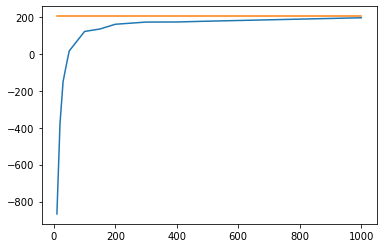

In [25]:
plt.plot(orbit_samples, elbos, "-")
plt.plot(orbit_samples, SVGPelbo.numpy() * np.ones(len(orbit_samples)))

I should somehow visualise the variation of the ELBO in this plot. Should also investigate the impact of g_samples.

## Non-Gaussian likelihood

I tried for the softmax, but there is some bug that I could not immediately solve. So I ran for the Bernoulli.

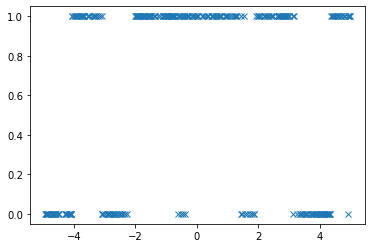

In [53]:
pX = np.linspace(-10.0, 10.0, 300)[:, None]
X = np.random.uniform(-5, 5, 300)[:, None]
Y = np.sin(3 * X) + 0.1  +  np.cos(0.5 * X) + np.random.randn(*X.shape) * 0.1
Y = (Y > 0).astype(int)
#Y = np.sign(Y).astype(int)
Z = np.linspace(-5, 5, 50)[:, None]

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

plt.plot(X,Y ,"x")

In [37]:
orbit_variance = 0.1

det_k = GaussianNoiseInvariant(orbit_variance=orbit_variance)

In [82]:
SVGPmodel = SVGP(det_k, likelihood = gpflow.likelihoods.Bernoulli(), 
                 num_data = len(X),
                 inducing_variable=GaussianNoiseInvariantInducing(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = SVGPmodel.training_loss_closure(train_iter, compile=False) # Compile not working for softmax-likelihood
optimizer = tf.keras.optimizers.Adam(0.01)
#@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGPmodel.trainable_variables)
elbo_hist = []
for step in range(2000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

SVGPelbo = SVGPmodel.elbo((X,Y))

Step: 0, Mini batch elbo: -551.8444635613425
Step: 50, Mini batch elbo: -95.00619621308789
Step: 100, Mini batch elbo: -75.48077724419781
Step: 150, Mini batch elbo: -71.44200488614527
Step: 200, Mini batch elbo: -79.3262496985071
Step: 250, Mini batch elbo: -74.48598625938409
Step: 300, Mini batch elbo: -71.07669508114928
Step: 350, Mini batch elbo: -69.79652243143104
Step: 400, Mini batch elbo: -69.13287227387768
Step: 450, Mini batch elbo: -68.67366493780446
Step: 500, Mini batch elbo: -68.3374230723133
Step: 550, Mini batch elbo: -68.1015504936784
Step: 600, Mini batch elbo: -67.89659709192318
Step: 650, Mini batch elbo: -67.73573330004697
Step: 700, Mini batch elbo: -67.600917820126
Step: 750, Mini batch elbo: -67.4832681117552
Step: 800, Mini batch elbo: -67.37873555299063
Step: 850, Mini batch elbo: -67.28380357658304
Step: 900, Mini batch elbo: -67.19735837573563
Step: 950, Mini batch elbo: -67.11372002298383
Step: 1000, Mini batch elbo: -67.03639043979234
Step: 1050, Mini batc

In [71]:
SVGPmodel.elbo((X,Y))

<tf.Tensor: shape=(), dtype=float64, numpy=-117.14858843169101>

In [83]:
orbit_samples = [10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 1000]
g_samples = 10
elbos = []

for os in orbit_samples:
    stoch_k = invgp.kernels.StochasticInvariant(
        basekern=gpflow.kernels.SquaredExponential(variance = det_k.base_variance, lengthscales = det_k.base_lengthscales),
        orbit=orbits.GaussianNoiseOrbit(variance=orbit_variance,
                                  minibatch_size = os))

    sample_model = SampleSVGP(stoch_k,
                              inducing_variable = StochasticConvolvedInducingPoints(SVGPmodel.inducing_variable.Z), 
                              num_data = len(X),
                              likelihood = gpflow.likelihoods.Bernoulli(),
                              q_mu = SVGPmodel.q_mu.numpy(),
                              q_sqrt = SVGPmodel.q_sqrt.numpy(),
                              matheron_sampler = True, num_samples = g_samples)
    elbo = sample_model.elbo((X,Y))
    elbos.append(elbo.numpy())

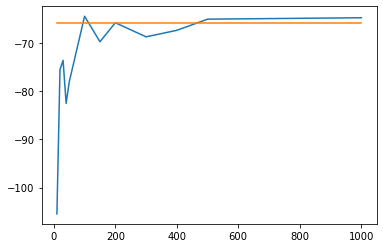

In [85]:
plt.plot(orbit_samples, elbos, "-")
plt.plot(orbit_samples, SVGPelbo.numpy() * np.ones(len(orbit_samples)))